# Algebraic Loop

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_algebraicloop.py).This example demonstrates PathSim's ability to handle **algebraic loops** - situations where a signal feeds back on itself instantaneously without any dynamic element (integrator, delay, etc.) in the loop.


## What is an Algebraic Loop?

An algebraic loop occurs when the output of a block depends on its own input in the same timestep. This creates an implicit equation that must be solved:

$$y = f(y)$$

## System Description

In this example:
- A **source** generates a sinusoidal signal: $s(t) = 2\cos(t)$
- An **amplifier** multiplies by gain $a = -0.2$
- An **adder** sums the source and amplifier output
- The amplifier input comes from the adder output, creating a loop

This creates the algebraic equation:
$$y = s(t) + a \cdot y$$

Which has the analytical solution:
$$y = \frac{s(t)}{1 - a} = \frac{2\cos(t)}{1.2} = 1.667\cos(t)$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Source, Amplifier, Adder, Scope

## System Parameters

We define:
- Timestep: 0.1 s
- Algebraic feedback gain: $a = -0.2$

In [7]:
# Simulation timestep
dt = 0.1

# Algebraic feedback gain
a = -0.2

## Block Diagram


In [10]:
# Blocks that define the system
Src = Source(lambda t: 2*np.cos(t))
Amp = Amplifier(a)
Add = Adder()
Sco = Scope(labels=["src", "amp", "add"])

blocks = [Src, Amp, Add, Sco]

## Connections

Notice that the output of the `Add` block connects to the input of `Amp`, and the output of `Amp` connects back to the second input of `Add`. This creates the algebraic loop.

In [13]:
connections = [
    Connection(Src, Add),          # Source to adder input 0
    Connection(Add, Amp),          # Adder output to amplifier
    Connection(Amp, Add[1]),       # Amplifier back to adder input 1 (loop!)
    Connection(Src, Sco),          # Scopes for plotting
    Connection(Amp, Sco[1]),
    Connection(Add, Sco[2])
]

## Simulation

PathSim automatically detects the algebraic loop and solves it using fixed-point iteration at each timestep. No special configuration is needed!

In [16]:
# Initialize simulation with logging enabled
Sim = Simulation(blocks, connections, dt=dt, log=True)

# Run the simulation for 5 seconds
Sim.run(5)

2025-10-09 21:05:50,583 - INFO - LOGGING (log: True)
2025-10-09 21:05:50,585 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-09 21:05:50,585 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-10-09 21:05:50,585 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-09 21:05:50,586 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-09 21:05:50,586 - INFO - GRAPH (size: 4, alg. depth: 1, loop depth: 2, runtime: 0.098ms)
2025-10-09 21:05:50,587 - INFO - STARTING -> TRANSIENT (Duration: 5.00s)
2025-10-09 21:05:50,587 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-09 21:05:50,588 - INFO - TRANSIENT:  22% | elapsed: 00:00:00 (eta: --:--:--) | 11 steps (10658.9 steps/s)
2025-10-09 21:05:50,589 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: --:--:--) | 20 steps (10733.5 steps/s)
2025-10-09 21:05:50,590 - INFO - TRANSIENT:  60% | elapsed: 00:00:00 (eta: --:--:--) | 30 steps (8169.3 steps/s)
20

{'total_steps': 51, 'successful_steps': 51, 'runtime_ms': 5.722699919715524}

## Results

The plot shows:
- **src** (blue): Input signal = $2\cos(t)$
- **amp** (orange): Amplifier output = $-0.2 \times \text{add}$
- **add** (green): Adder output = $\frac{2\cos(t)}{1.2} \approx 1.667\cos(t)$

The algebraic loop is solved correctly at each timestep!

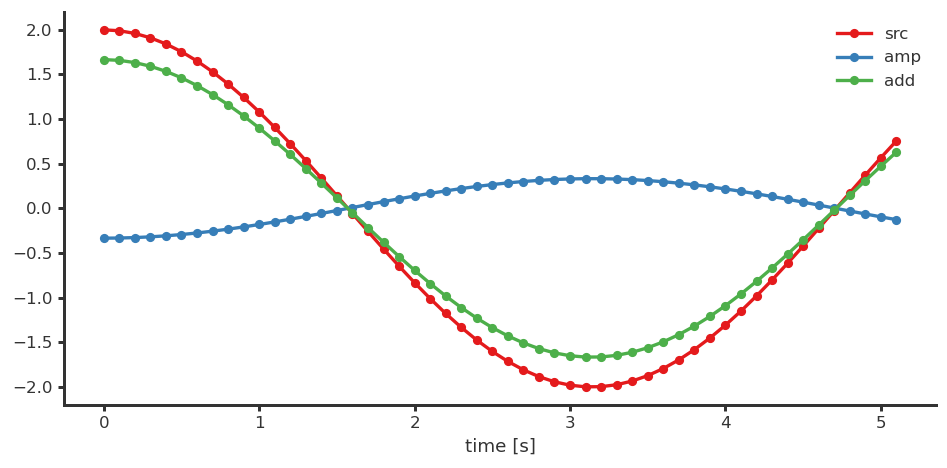

In [19]:
Sco.plot(".-")
plt.show()

## Verification

Let's verify the solution is correct by checking that the adder output matches the analytical solution.

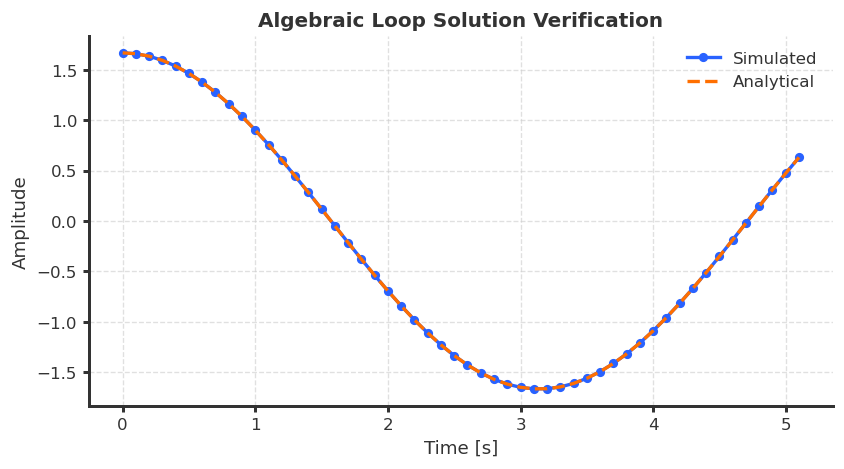

Maximum error: 2.22e-16


In [22]:
# Get simulation results
time, [src_sig, amp_sig, add_sig] = Sco.read()

# Analytical solution
analytical = 2*np.cos(time) / (1 - a)

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.plot(time, add_sig, 'o-', label='Simulated', markersize=4)
ax.plot(time, analytical, '--', label='Analytical', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Algebraic Loop Solution Verification')
ax.legend()
ax.grid(True)
plt.show()

# Compute error
error = np.max(np.abs(add_sig - analytical))
print(f"Maximum error: {error:.2e}")